In [1]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import WavLMModel, WavLMConfig, AutoFeatureExtractor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import librosa
import random
import math
import soundfile as sf

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

In [3]:
# Cell 3: Paths
# Assuming this notebook is in 'ml/' or 'ml/notebooks/' relative to project root
root_dir = Path('../')
data_dir = root_dir / 'data'

# Directory where the FINAL training metadata CSVs are stored
metadata_dir = data_dir / 'processed'

# Directory where the FINAL segmented/processed audio WAVs are stored
# This is the base for paths listed in the metadata CSVs
audio_base_dir = data_dir / 'combined' # Changed from processed_dir

# Directory for saving model checkpoints and plots
output_dir = data_dir / 'processed' # Or choose a different output dir like 'training_outputs'
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Root directory: {root_dir}")
print(f"Metadata directory: {metadata_dir}")
print(f"Audio base directory: {audio_base_dir}")
print(f"Output directory for checkpoints/plots: {output_dir}")

Root directory: ..
Metadata directory: ..\data\processed
Audio base directory: ..\data\combined
Output directory for checkpoints/plots: ..\data\processed


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
class_names = ['No Dementia', 'Dementia']
num_classes = 1

In [6]:
# Cell 7: DementiaAudioDataset (Modified for new structure)

class DementiaAudioDataset(Dataset):
    def __init__(self, metadata_df, audio_base_directory, feature_extractor, max_length=160000, augment=False):
        """
        Dataset for binary audio dementia classification using pre-processed data.

        Args:
            metadata_df: DataFrame containing 'relative_audio_path' and 'label' columns.
            audio_base_directory: Path object pointing to the base directory
                                    (e.g., 'data/combined') where relative_audio_path starts.
            feature_extractor: WavLM feature extractor.
            max_length: Maximum audio length in samples (e.g., 10s @ 16kHz = 160000).
            augment: Whether to apply augmentation during training.
        """
        self.df = metadata_df
        self.audio_base_dir = Path(audio_base_directory) # Ensure it's a Path object
        self.feature_extractor = feature_extractor
        self.max_length = max_length
        self.augment = augment
        self.sampling_rate = 16000 # Target sampling rate

    def __len__(self):
        return len(self.df)

    def _load_audio(self, audio_path: Path):
        # Load audio
        if not audio_path.is_file():
             print(f"ERROR: Audio file not found at: {audio_path}")
             return np.zeros(self.max_length) # Return zeros if file missing

        try:
            # Use soundfile for potentially faster WAV loading
            waveform, sr = sf.read(audio_path, dtype='float32')
            # Verify sample rate after loading
            if sr != self.sampling_rate:
                 print(f"Warning: File {audio_path.name} has incorrect sample rate {sr}, expected {self.sampling_rate}. Skipping or add resampling.")
                 # Option 1: Skip - return zeros
                 # return np.zeros(self.max_length)
                 # Option 2: Resample (requires librosa or torchaudio) - Using librosa for simplicity here
                 # waveform = librosa.resample(waveform, orig_sr=sr, target_sr=self.sampling_rate)
                 # --- Let's assume preprocessing handled this, return zeros if mismatch ---
                 print(f"ERROR: Mismatched sample rate for {audio_path.name}. Expected {self.sampling_rate}, got {sr}.")
                 return np.zeros(self.max_length)

            # Ensure mono (soundfile loads mono as 1D, stereo as 2D)
            if waveform.ndim > 1:
                # Simple average for stereo to mono conversion
                waveform = np.mean(waveform, axis=1)

        except Exception as e:
            print(f"Error loading audio file {audio_path}: {e}")
            return np.zeros(self.max_length) # Return zeros as a fallback

        # Apply augmentation if requested
        if self.augment:
            # Librosa augmentations require sample rate argument if not loaded with librosa
            sr_for_augment = self.sampling_rate
            # Random volume change
            if random.random() < 0.3:
                # Normalize first to apply gain relative to RMS/peak
                norm_factor = np.max(np.abs(waveform))
                if norm_factor > 1e-6: # Avoid division by zero
                    waveform_norm = waveform / norm_factor
                else:
                    waveform_norm = waveform
                db_change = random.uniform(-10, 10)
                waveform = waveform_norm * (10 ** (db_change / 20)) * norm_factor

            # Pitch shift (can be slow)
            if random.random() < 0.5:
                semitones = random.uniform(-4, 4)
                waveform = librosa.effects.pitch_shift(y=waveform, sr=sr_for_augment, n_steps=semitones)

            # Time stretch (can be slow, changes length)
            if random.random() < 0.5:
                rate = random.uniform(0.85, 1.15) # Slightly smaller range
                try:
                    waveform = librosa.effects.time_stretch(y=waveform, rate=rate)
                except Exception as ts_err:
                    print(f"Warning: Time stretch failed for a sample: {ts_err}")


        # Pad or truncate AFTER potential time stretch
        current_len = len(waveform)
        if current_len > self.max_length:
            waveform = waveform[:self.max_length]
        elif current_len < self.max_length:
            padding = self.max_length - current_len
            waveform = np.pad(waveform, (0, padding), 'constant')
        # else: length is exactly max_length

        return waveform

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        relative_path = row['relative_audio_path']
        label = row['label']

        # Construct the full path using the base directory
        # Ensure relative_path doesn't start with a slash if base_dir is used
        full_audio_path = self.audio_base_dir / relative_path

        # Load and preprocess audio
        waveform = self._load_audio(full_audio_path)

        # Convert to tensor
        # Need to handle potential all-zero waveform if loading failed
        if np.all(waveform == 0):
             print(f"Warning: Waveform is all zeros for index {idx}, path {full_audio_path}. Check loading errors.")
             # Create zero inputs for the model to handle gracefully downstream if needed
             inputs = self.feature_extractor(waveform, sampling_rate=self.sampling_rate, return_tensors="pt", padding=True, truncation=True, max_length=self.max_length) # Use FE padding? might not match exactly
             # Or manually create zero tensor of expected feature size if known? Less robust.
        else:
             inputs = self.feature_extractor(waveform, sampling_rate=self.sampling_rate, return_tensors="pt")

        # Squeeze batch dimension added by feature extractor
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}

        # Return label as float for BCEWithLogitsLoss
        return inputs, torch.tensor(label, dtype=torch.float)

In [7]:
class WavLMForDementiaClassification(nn.Module):
    def __init__(self, base_model_name, num_classes=4):
        super(WavLMForDementiaClassification, self).__init__()
        
        # Load pre-trained WavLM model
        self.wavlm = WavLMModel.from_pretrained(base_model_name)
        hidden_size = self.wavlm.config.hidden_size
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1) # Output 1 logit for binary classification
        )
    
    def freeze_feature_extractor(self):
        """Freeze the feature extraction part of the model"""
        for param in self.wavlm.feature_extractor.parameters():
            param.requires_grad = False
    
    def unfreeze_feature_extractor(self):
        """Unfreeze the feature extraction part of the model"""
        for param in self.wavlm.feature_extractor.parameters():
            param.requires_grad = True
    
    def forward(self, input_values, attention_mask=None):
        outputs = self.wavlm(input_values=input_values, attention_mask=attention_mask)
        
        pooled_output = outputs.last_hidden_state.mean(dim=1)

        # Classification
        logits = self.classifier(pooled_output)
        return logits

In [8]:
# Cell 10: train_model function (Updated)

def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device, phase_name, start_epoch=0, best_val_f1=0.0):
    """Train the model on the training set and evaluate on validation set.
       Handles starting from a specific epoch and best F1 score for checkpointing."""
    criterion = nn.BCEWithLogitsLoss() # REMOVED pos_weight as data is balanced

    # best_val_f1 is now passed as argument, initialized outside if not resuming

    train_losses, val_losses = [], []
    train_f1s, val_f1s = [], []

    print(f"Starting training phase {phase_name} from Epoch {start_epoch + 1}/{num_epochs}")

    # --- Training Loop ---
    for epoch in range(start_epoch, num_epochs):
        current_epoch = epoch + 1
        print(f"Epoch {current_epoch}/{num_epochs}")

        # Training
        model.train()
        train_loss = 0.0
        y_true_train, y_pred_train = [], []

        for inputs, labels in tqdm(train_loader, desc="Training"):
            input_values = inputs['input_values'].to(device)
            attention_mask = inputs.get('attention_mask', None)
            if attention_mask is not None:
                attention_mask = attention_mask.to(torch.bool).to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            # Use autocast for mixed precision
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                outputs = model(input_values=input_values, attention_mask=attention_mask)
                loss = criterion(outputs, labels.unsqueeze(1))

            # Scaler is used for backward pass
            # loss.backward() # Replace with scaler
            # optimizer.step() # Replace with scaler
            # --- AMP Changes Start ---
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            # --- AMP Changes End ---


            train_loss += loss.item()
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).squeeze(1).long()
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predictions.cpu().numpy())


        # Compute epoch metrics
        train_loss /= len(train_loader)
        train_f1 = f1_score(y_true_train, y_pred_train, average='binary', pos_label=1, zero_division=0)
        train_losses.append(train_loss)
        train_f1s.append(train_f1)

        # Validation
        model.eval()
        val_loss = 0.0
        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                input_values = inputs['input_values'].to(device)
                attention_mask = inputs.get('attention_mask', None)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(torch.bool).to(device)
                labels = labels.to(device)

                # Use autocast for validation too (consistency, though not strictly needed for grads)
                with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                    outputs = model(input_values=input_values, attention_mask=attention_mask)
                    loss = criterion(outputs, labels.unsqueeze(1))

                val_loss += loss.item()
                probabilities = torch.sigmoid(outputs)
                predictions = (probabilities > 0.5).squeeze(1).long()
                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(predictions.cpu().numpy())


        # Compute epoch metrics
        val_loss /= len(val_loader)
        val_f1 = f1_score(y_true_val, y_pred_val, average='binary', pos_label=1, zero_division=0)
        # val_precision = precision_score(y_true_val, y_pred_val, average='binary', pos_label=1, zero_division=0) # Can add back if needed
        # val_recall = recall_score(y_true_val, y_pred_val, average='binary', pos_label=1, zero_division=0) # Can add back if needed
        val_losses.append(val_loss)
        val_f1s.append(val_f1)

        # --- Checkpoint Saving Logic ---
        is_best = val_f1 >= best_val_f1
        if is_best:
            old_best_f1 = best_val_f1
            best_val_f1 = val_f1

            checkpoint = {
                'epoch': current_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'best_val_f1': best_val_f1,
                'phase_name': phase_name,
                'scaler_state_dict': scaler.state_dict() # --- Add scaler state ---
            }
            # Use output_dir defined in Cell 3 for saving
            checkpoint_path = output_dir / f'checkpoint_{phase_name}_final_data.pt' # Updated filename

            print(f"Validation F1 improved or matched ({old_best_f1:.4f} --> {best_val_f1:.4f}). Saving checkpoint to {checkpoint_path}")
            torch.save(checkpoint, checkpoint_path)

            # Detailed evaluation metrics printout (keep as is)
            # ... (print metrics logic - check confusion matrix index safety) ...
            print("Best model state updated! Detailed validation metrics (Binary):")
            accuracy = accuracy_score(y_true_val, y_pred_val)
            precision_pos = precision_score(y_true_val, y_pred_val, pos_label=1, zero_division=0)
            recall_pos = recall_score(y_true_val, y_pred_val, pos_label=1, zero_division=0)
            f1_pos = f1_score(y_true_val, y_pred_val, pos_label=1, zero_division=0)
            precision_neg = precision_score(y_true_val, y_pred_val, pos_label=0, zero_division=0)
            recall_neg = recall_score(y_true_val, y_pred_val, pos_label=0, zero_division=0)
            f1_neg = f1_score(y_true_val, y_pred_val, pos_label=0, zero_division=0)
            conf_matrix = confusion_matrix(y_true_val, y_pred_val, labels=[0, 1])
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Dementia (Pos) Precision: {precision_pos:.4f}")
            print(f"Dementia (Pos) Recall: {recall_pos:.4f}")
            print(f"Dementia (Pos) F1: {f1_pos:.4f}")
            print(f"No Dementia (Neg) Precision: {precision_neg:.4f}")
            print(f"No Dementia (Neg) Recall: {recall_neg:.4f}")
            print(f"No Dementia (Neg) F1: {f1_neg:.4f}")
            print("Confusion Matrix (Rows=True, Cols=Pred):")
            print("  Pred: NoDem Dem")
            print(f"True:")
            # Safer printing for confusion matrix
            cm_shape = conf_matrix.shape
            print(f"NoDem   {conf_matrix[0,0] if cm_shape[0]>0 and cm_shape[1]>0 else 0:<3} {conf_matrix[0,1] if cm_shape[0]>0 and cm_shape[1]>1 else 0:<3}")
            print(f"Dem     {conf_matrix[1,0] if cm_shape[0]>1 and cm_shape[1]>0 else 0:<3} {conf_matrix[1,1] if cm_shape[0]>1 and cm_shape[1]>1 else 0:<3}")


        # --- Update learning rate AFTER saving checkpoint ---
        if scheduler:
            # Note: Scheduler step might need adjustment depending on AMP scaler state,
            # but typically called after optimizer step/update. Check specific scheduler docs if issues arise.
             scheduler.step()


        # Print epoch summary (always print)
        print(f"Epoch {current_epoch} Summary: Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")
        print("-" * 50)
        # --- End Epoch Loop ---


    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))
    # Adjust x-axis range for plotting
    epochs_run = range(start_epoch, num_epochs)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_run, train_losses, label="Train")
    plt.plot(epochs_run, val_losses, label="Validation")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_run, train_f1s, label="Train")
    plt.plot(epochs_run, val_f1s, label="Validation")
    plt.title("F1 Score (Dementia Class)")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # Use output_dir for saving plots
    plt.savefig(output_dir / f'training_metrics_{phase_name}_final_data.png') # Updated filename
    plt.show()


    # --- Load the Best Model state from the saved checkpoint file ---
    best_checkpoint_path = output_dir / f'checkpoint_{phase_name}_final_data.pt'
    if best_checkpoint_path.exists():
        print(f"Loading best model state from checkpoint: {best_checkpoint_path}")
        # Load checkpoint onto the correct device
        checkpoint = torch.load(best_checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Best model loaded (Epoch {checkpoint.get('epoch', '?')}, Val F1: {checkpoint.get('best_val_f1', '?'):.4f})")
    else:
        print(f"Warning: No checkpoint found at {best_checkpoint_path}. Returning model in its current state (after last epoch).")

    return model # Return the model loaded with the best state found during this run

In [9]:
# Cell 11: plot_confusion_matrix (Updated save path)

def plot_confusion_matrix(y_true, y_pred, class_names): # class_names will be ['No Dementia', 'Dementia']
    # Ensure labels cover the full range if only one class is predicted
    labels_present = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1]) # Explicitly use labels=[0, 1]
    plt.figure(figsize=(6, 5)) # Smaller figure for 2x2
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    # Use output_dir for saving plots and new filename
    plt.savefig(output_dir / 'confusion_matrix_final_data.png') # Use output_dir and updated name
    plt.show()

In [10]:
# Cell 12: Load FINAL Balanced Data, Create Datasets/Loaders (Increased Batch Size & Workers)

print("Loading FINAL balanced & segmented metadata splits...")
# Use metadata_dir defined in Cell 3
train_metadata_path = metadata_dir / 'train_meta_len_filtered_balanced.csv'
val_metadata_path = metadata_dir / 'val_meta_len_filtered_balanced.csv'
test_metadata_path = metadata_dir / 'test_meta_len_filtered_balanced.csv'

try:
    # --- Load Full Data ---
    df_train_full = pd.read_csv(train_metadata_path)
    df_val_full = pd.read_csv(val_metadata_path)
    df_test = pd.read_csv(test_metadata_path) # Keep full test set for now

    print(f"Loaded Full Train metadata: {len(df_train_full)} samples ({df_train_full['label'].value_counts().to_dict()})")
    print(f"Loaded Full Validation metadata: {len(df_val_full)} samples ({df_val_full['label'].value_counts().to_dict()})")
    print(f"Loaded Test metadata: {len(df_test)} samples ({df_test['label'].value_counts().to_dict()})")

    # --- Use Full Dataset ---  MODIFIED TO USE FULL DATASET
    df_train = df_train_full # Use the full training data
    df_val = df_val_full     # Use the full validation data
    print(f"Using Full Train data: {len(df_train)} samples ({df_train['label'].value_counts().to_dict()})")
    print(f"Using Full Validation data: {len(df_val)} samples ({df_val['label'].value_counts().to_dict()})")

except FileNotFoundError as e:
     print(f"ERROR: Could not load final metadata files: {e}")
     print("Please ensure the 'Prepare_Control_Data...' notebook ran successfully and generated these files.")
     raise
except Exception as e:
     print(f"Error loading metadata: {e}")
     raise


# --- Remove pos_weight calculation ---
# Data is now balanced by undersampling controls in the prep script.
# No change needed here for sampling


# Load feature extractor
base_model_name = "microsoft/wavlm-base-plus"
print(f"\nLoading feature extractor from {base_model_name}")
feature_extractor = AutoFeatureExtractor.from_pretrained(base_model_name)

# Create datasets using the FINAL metadata DataFrames
# Pass the audio_base_dir to the Dataset constructor
print("\nCreating datasets...")
train_dataset = DementiaAudioDataset(
    metadata_df=df_train, # Use the FULL training dataframe
    audio_base_directory=audio_base_dir, # Pass base dir for audio files
    feature_extractor=feature_extractor,
    max_length=160000,
    augment=True
)
val_dataset = DementiaAudioDataset(
    metadata_df=df_val, # Use the FULL validation dataframe
    audio_base_directory=audio_base_dir, # Pass base dir
    feature_extractor=feature_extractor,
    max_length=160000,
    augment=False
)
test_dataset = DementiaAudioDataset(
    metadata_df=df_test, # Use the FULL test dataframe
    audio_base_directory=audio_base_dir, # Pass base dir
    feature_extractor=feature_extractor,
    max_length=160000,
    augment=False
)

# Create data loaders
# --- Increased batch size and num_workers ---
batch_size = 4 # Increased from 16 (adjust based on GPU memory)
num_workers = 0 # Increased from 2 (adjust based on CPU cores/RAM) <-- KEPT AT 0 AS REQUESTED
# --- End of changes ---

# Recommended DataLoader settings for CUDA:
# - num_workers > 0 enables parallel loading
# - pin_memory=True speeds up CPU->GPU transfer if using GPU
# - persistent_workers=True (PyTorch 1.7+) keeps workers alive between epochs, reduces startup overhead
# - prefetch_factor (PyTorch 1.7+) controls how many batches workers prepare ahead
try:
     # Use newer args if available
     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True if device=='cuda' else False, persistent_workers=True if num_workers>0 else False, prefetch_factor=2 if num_workers>0 else None)
     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True if device=='cuda' else False, persistent_workers=True if num_workers>0 else False, prefetch_factor=2 if num_workers>0 else None)
     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True if device=='cuda' else False, persistent_workers=True if num_workers>0 else False, prefetch_factor=2 if num_workers>0 else None)
     print("Using DataLoader with persistent_workers=True and prefetch_factor=2")
except TypeError:
     # Fallback for older PyTorch versions
     print("Warning: persistent_workers/prefetch_factor not supported by this PyTorch version. Using basic DataLoader.")
     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True if device=='cuda' else False)
     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True if device=='cuda' else False)
     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True if device=='cuda' else False)


print(f"\nFinal DataLoaders:")
print(f"Train samples: {len(train_dataset)} (Full)") # Updated print statement
print(f"Validation samples: {len(val_dataset)} (Full)") # Updated print statement
print(f"Test samples: {len(test_dataset)}") # Kept full test set
print(f"Batch Size: {batch_size}")
print(f"Num Workers: {num_workers}") # Explicitly 0

# Estimate new number of batches
new_train_batches = math.ceil(len(train_dataset) / batch_size)
print(f"Estimated batches per training epoch: {new_train_batches}")

# # Cell 12: Load FINAL Balanced Data, Create Datasets/Loaders (Increased Batch Size & Workers)

# print("Loading FINAL balanced & segmented metadata splits...")
# # Use metadata_dir defined in Cell 3
# train_metadata_path = metadata_dir / 'train_meta_len_filtered_balanced.csv'
# val_metadata_path = metadata_dir / 'val_meta_len_filtered_balanced.csv'
# test_metadata_path = metadata_dir / 'test_meta_len_filtered_balanced.csv'

# try:
#     # --- Load Full Data ---
#     df_train_full = pd.read_csv(train_metadata_path)
#     df_val_full = pd.read_csv(val_metadata_path)
#     df_test = pd.read_csv(test_metadata_path) # Keep full test set for now

#     print(f"Loaded Full Train metadata: {len(df_train_full)} samples ({df_train_full['label'].value_counts().to_dict()})")
#     print(f"Loaded Full Validation metadata: {len(df_val_full)} samples ({df_val_full['label'].value_counts().to_dict()})")
#     print(f"Loaded Test metadata: {len(df_test)} samples ({df_test['label'].value_counts().to_dict()})")

#     # --- Sample 10% of Train and Validation Data ---
#     train_sample_frac = 0.10
#     val_sample_frac = 0.10

#     # Use stratified sampling to maintain class balance
#     from sklearn.model_selection import train_test_split # Ensure this is imported

#     # Sample training data
#     if len(df_train_full) > 1: # Need at least 2 samples for train_test_split
#          df_train, _ = train_test_split(
#              df_train_full,
#              train_size=train_sample_frac,
#              random_state=42,
#              stratify=df_train_full['label']
#          )
#          print(f"Using {train_sample_frac*100:.1f}% sample of Train data: {len(df_train)} samples ({df_train['label'].value_counts().to_dict()})")
#     else:
#          print("Warning: Full training dataset too small to sample.")
#          df_train = df_train_full # Use the full (tiny) set

#     # Sample validation data
#     if len(df_val_full) > 1:
#          df_val, _ = train_test_split(
#              df_val_full,
#              train_size=val_sample_frac,
#              random_state=42,
#              stratify=df_val_full['label']
#          )
#          print(f"Using {val_sample_frac*100:.1f}% sample of Validation data: {len(df_val)} samples ({df_val['label'].value_counts().to_dict()})")
#     else:
#          print("Warning: Full validation dataset too small to sample.")
#          df_val = df_val_full # Use the full (tiny) set

# except FileNotFoundError as e:
#      print(f"ERROR: Could not load final metadata files: {e}")
#      print("Please ensure the 'Prepare_Control_Data...' notebook ran successfully and generated these files.")
#      raise
# except Exception as e:
#      print(f"Error loading metadata: {e}")
#      raise


# # --- Remove pos_weight calculation ---
# # Data is now balanced by undersampling controls in the prep script.
# # No change needed here for sampling


# # Load feature extractor
# base_model_name = "microsoft/wavlm-base-plus"
# print(f"\nLoading feature extractor from {base_model_name}")
# feature_extractor = AutoFeatureExtractor.from_pretrained(base_model_name)

# # Create datasets using the FINAL metadata DataFrames
# # Pass the audio_base_dir to the Dataset constructor
# print("\nCreating datasets...")
# train_dataset = DementiaAudioDataset(
#     metadata_df=df_train, # Use the SAMPLED training dataframe
#     audio_base_directory=audio_base_dir, # Pass base dir for audio files
#     feature_extractor=feature_extractor,
#     max_length=160000,
#     augment=True
# )
# val_dataset = DementiaAudioDataset(
#     metadata_df=df_val, # Use the SAMPLED validation dataframe
#     audio_base_directory=audio_base_dir, # Pass base dir
#     feature_extractor=feature_extractor,
#     max_length=160000,
#     augment=False
# )
# test_dataset = DementiaAudioDataset(
#     metadata_df=df_test, # Use the FULL test dataframe
#     audio_base_directory=audio_base_dir, # Pass base dir
#     feature_extractor=feature_extractor,
#     max_length=160000,
#     augment=False
# )

# # Create data loaders
# # --- Increased batch size and num_workers ---
# batch_size = 16 # Increased from 16 (adjust based on GPU memory)
# num_workers = 0 # Increased from 2 (adjust based on CPU cores/RAM) <-- You should INCREASE this later!
# # --- End of changes ---

# # Recommended DataLoader settings for CUDA:
# # - num_workers > 0 enables parallel loading
# # - pin_memory=True speeds up CPU->GPU transfer if using GPU
# # - persistent_workers=True (PyTorch 1.7+) keeps workers alive between epochs, reduces startup overhead
# # - prefetch_factor (PyTorch 1.7+) controls how many batches workers prepare ahead
# try:
#      # Use newer args if available
#      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True if device=='cuda' else False, persistent_workers=True if num_workers>0 else False, prefetch_factor=2 if num_workers>0 else None)
#      val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True if device=='cuda' else False, persistent_workers=True if num_workers>0 else False, prefetch_factor=2 if num_workers>0 else None)
#      test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True if device=='cuda' else False, persistent_workers=True if num_workers>0 else False, prefetch_factor=2 if num_workers>0 else None)
#      print("Using DataLoader with persistent_workers=True and prefetch_factor=2")
# except TypeError:
#      # Fallback for older PyTorch versions
#      print("Warning: persistent_workers/prefetch_factor not supported by this PyTorch version. Using basic DataLoader.")
#      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True if device=='cuda' else False)
#      val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True if device=='cuda' else False)
#      test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True if device=='cuda' else False)


# print(f"\nFinal DataLoaders:")
# print(f"Train samples: {len(train_dataset)} (Sampled)") # Updated print statement
# print(f"Validation samples: {len(val_dataset)} (Sampled)") # Updated print statement
# print(f"Test samples: {len(test_dataset)}") # Kept full test set
# print(f"Batch Size: {batch_size}")
# print(f"Num Workers: {num_workers}") # Reminder: Increase this later

# # Estimate new number of batches
# new_train_batches = math.ceil(len(train_dataset) / batch_size)
# print(f"Estimated batches per training epoch: {new_train_batches}")

Loading FINAL balanced & segmented metadata splits...
Loaded Full Train metadata: 39440 samples ({0: 19720, 1: 19720})
Loaded Full Validation metadata: 4930 samples ({1: 2465, 0: 2465})
Loaded Test metadata: 4930 samples ({0: 2465, 1: 2465})
Using Full Train data: 39440 samples ({0: 19720, 1: 19720})
Using Full Validation data: 4930 samples ({1: 2465, 0: 2465})

Loading feature extractor from microsoft/wavlm-base-plus

Creating datasets...
Using DataLoader with persistent_workers=True and prefetch_factor=2

Final DataLoaders:
Train samples: 39440 (Full)
Validation samples: 4930 (Full)
Test samples: 4930
Batch Size: 4
Num Workers: 0
Estimated batches per training epoch: 9860


In [11]:
print(f"Initializing model with base model: {base_model_name}")
model = WavLMForDementiaClassification(base_model_name, num_classes=num_classes).to(device)

Initializing model with base model: microsoft/wavlm-base-plus


In [12]:
# Cell 13.5: Initialize AMP GradScaler

# Initialize GradScaler for Automatic Mixed Precision
# Enable only if device is cuda
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))
print(f"AMP GradScaler Initialized (Device: {device.type}, Enabled: {scaler.is_enabled()})")

AMP GradScaler Initialized (Device: cuda, Enabled: True)


In [13]:
# Cell 14: Phase 1 Training Call (Updated)

# --- Checkpoint Loading Logic ---
# Define checkpoint paths using output_dir and updated filenames
phase1_checkpoint_path = output_dir / 'checkpoint_phase1_binary_final_data.pt'
phase2_checkpoint_path = output_dir / 'checkpoint_phase2_binary_final_data.pt'

# Variables for resuming
start_epoch_phase1 = 0
best_val_f1_phase1 = 0.0
optimizer_state_phase1 = None
scheduler_state_phase1 = None
scaler_state_phase1 = None # <-- Add scaler state

start_epoch_phase2 = 0
best_val_f1_phase2 = 0.0
optimizer_state_phase2 = None
scheduler_state_phase2 = None
scaler_state_phase2 = None # <-- Add scaler state

load_checkpoint_path = None
if phase2_checkpoint_path.exists():
    print(f"Phase 2 checkpoint found: {phase2_checkpoint_path}. Loading state.")
    load_checkpoint_path = phase2_checkpoint_path
elif phase1_checkpoint_path.exists():
    print(f"Phase 1 checkpoint found: {phase1_checkpoint_path}. Loading state.")
    load_checkpoint_path = phase1_checkpoint_path
else:
    print("No checkpoints found. Starting training from scratch.")

if load_checkpoint_path:
    try:
        checkpoint = torch.load(load_checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])

        phase_loaded = checkpoint.get('phase_name', None)
        epoch_loaded = checkpoint.get('epoch', 0)
        best_f1_loaded = checkpoint.get('best_val_f1', 0.0)
        opt_state_loaded = checkpoint.get('optimizer_state_dict')
        sch_state_loaded = checkpoint.get('scheduler_state_dict')
        scl_state_loaded = checkpoint.get('scaler_state_dict') # <-- Load scaler state

        print(f"Checkpoint loaded from Phase: {phase_loaded}, Epoch: {epoch_loaded}, Best Val F1: {best_f1_loaded:.4f}")

        if phase_loaded == "phase1_binary":
             start_epoch_phase1 = epoch_loaded # Resume AFTER this epoch
             best_val_f1_phase1 = best_f1_loaded
             optimizer_state_phase1 = opt_state_loaded
             scheduler_state_phase1 = sch_state_loaded
             scaler_state_phase1 = scl_state_loaded # <-- Store scaler state
             if start_epoch_phase1 >= 3: # Check if phase 1 finished
                  print("Phase 1 seems complete in checkpoint. Preparing for Phase 2.")
                  start_epoch_phase1 = 3 # Ensure phase 1 is skipped

        elif phase_loaded == "phase2_binary":
             start_epoch_phase2 = epoch_loaded # Resume AFTER this epoch
             best_val_f1_phase2 = best_f1_loaded
             optimizer_state_phase2 = opt_state_loaded
             scheduler_state_phase2 = sch_state_loaded
             scaler_state_phase2 = scl_state_loaded # <-- Store scaler state
             # If resuming phase 2, skip phase 1 completely
             start_epoch_phase1 = 3 # Set phase 1 to max epochs

    except Exception as e:
        print(f"Error loading checkpoint: {e}. Restarting training.")
        # Reset all resume variables
        start_epoch_phase1 = 0; best_val_f1_phase1 = 0.0; optimizer_state_phase1 = None; scheduler_state_phase1 = None; scaler_state_phase1 = None;
        start_epoch_phase2 = 0; best_val_f1_phase2 = 0.0; optimizer_state_phase2 = None; scheduler_state_phase2 = None; scaler_state_phase2 = None;


# --- Phase 1 Training ---
num_epochs_phase1 = 3

if start_epoch_phase1 < num_epochs_phase1:
    print(f"\n--- Starting/Resuming Phase 1 (Epochs {start_epoch_phase1 + 1} to {num_epochs_phase1}) ---")
    model.freeze_feature_extractor() # Ensure correct state

    # Create optimizer/scheduler for PHASE 1
    optimizer_phase1 = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()), # Only pass parameters requiring grad
        lr=5e-5, weight_decay=0.01
    )
    # Adjust steps based on remaining epochs
    total_steps_phase1 = len(train_loader) * (num_epochs_phase1 - start_epoch_phase1)
    warmup_steps_phase1 = int(0.1 * total_steps_phase1) if total_steps_phase1 > 0 else 0
    scheduler_phase1 = optim.lr_scheduler.LinearLR(
        optimizer_phase1, start_factor=0.1, end_factor=1.0, total_iters=max(1, warmup_steps_phase1)
    )

    # Load states if resuming this specific phase
    if optimizer_state_phase1:
        print("Loading Phase 1 optimizer state...")
        optimizer_phase1.load_state_dict(optimizer_state_phase1)
    if scheduler_state_phase1 and scheduler_phase1:
        print("Loading Phase 1 scheduler state...")
        scheduler_phase1.load_state_dict(scheduler_state_phase1)
    if scaler_state_phase1 and scaler.is_enabled(): # <-- Load scaler state
        print("Loading Phase 1 GradScaler state...")
        scaler.load_state_dict(scaler_state_phase1)


    # Run training for phase 1
    model = train_model(
        model=model, train_loader=train_loader, val_loader=val_loader,
        optimizer=optimizer_phase1, scheduler=scheduler_phase1,
        num_epochs=num_epochs_phase1, device=device, phase_name="phase1_binary",
        start_epoch=start_epoch_phase1, best_val_f1=best_val_f1_phase1
    )
else:
    print("\n--- Skipping Phase 1 (already completed or resuming Phase 2) ---")

Phase 1 checkpoint found: ..\data\processed\checkpoint_phase1_binary_final_data.pt. Loading state.
Checkpoint loaded from Phase: phase1_binary, Epoch: 3, Best Val F1: 0.9899
Phase 1 seems complete in checkpoint. Preparing for Phase 2.

--- Skipping Phase 1 (already completed or resuming Phase 2) ---



--- Starting/Resuming Phase 2 (Epochs 1 to 1) ---
Starting training phase phase2_binary from Epoch 1/1
Epoch 1/1


Training:   0%|                                                                               | 0/9860 [00:00<?, ?it/s]D:\Cornell\Academic\Spring 2025\Startup Studio\MVP\neurotone\ml\.venv\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Training:   0%|▎                                                                   | 46/9860 [00:31<1:27:58,  1.86it/s]

Training:   1%|▌                                                                   | 80/9860 [00:50<1:27:51,  1.86it/s]

Training:   1%|▋                                                                  | 101/9860 [01:03<1:35:24,  1.70it/s]

Training:   4%|██▍                                                                | 362/9860 [03:45<1:47:28,  1.47it/s]

Training:  10%|██████▊                                                           | 1019/9860 [10:23<1:34:36,  1.56it/s]

Training:  12%|███████▊                                                          | 1165/9860 [11:49<1:40:45,  1.44it/s]

Training:  12%|████████                                                          | 1207/9860 [12:15<1:22:43,  1.74it/s]

Training:  15%|██████████▏                                                       | 1516/9860 [15:21<1:32:15,  1.51it/s]

Training:  19%|████████████▍                                                     | 1866/9860 [18:56<1:17:31,  1.72it/s]

Training:  22%|██████████████▍                                                   | 2159/9860 [22:00<1:28:30,  1.45it/s]

Training:  24%|███████████████▌                                                  | 2324/9860 [23:40<1:06:07,  1.90it/s]

Training:  24%|███████████████▊                                                  | 2368/9860 [24:06<1:04:08,  1.95it/s]

Training:  25%|████████████████▊                                                 | 2511/9860 [25:32<1:13:41,  1.66it/s]

Training:  26%|█████████████████▏                                                | 2576/9860 [26:09<1:08:43,  1.77it/s]

Training:  30%|███████████████████▌                                              | 2916/9860 [29:33<1:19:19,  1.46it/s]

Training:  35%|██████████████████████▉                                           | 3426/9860 [34:42<1:04:34,  1.66it/s]

Training:  35%|███████████████████████▋                                            | 3435/9860 [34:47<54:36,  1.96it/s]

Training:  41%|████████████████████████████                                        | 4061/9860 [41:03<54:31,  1.77it/s]

Training:  42%|████████████████████████████▊                                       | 4173/9860 [42:12<57:27,  1.65it/s]

Training:  43%|████████████████████████████▉                                       | 4192/9860 [42:23<51:49,  1.82it/s]

Training:  46%|███████████████████████████████                                     | 4513/9860 [45:25<56:31,  1.58it/s]

Training:  48%|████████████████████████████████▋                                   | 4745/9860 [47:35<50:51,  1.68it/s]

Training:  50%|█████████████████████████████████▉                                  | 4921/9860 [49:15<42:52,  1.92it/s]

Training:  54%|█████████████████████████████████████                               | 5368/9860 [53:32<39:51,  1.88it/s]

Training:  55%|█████████████████████████████████████▌                              | 5448/9860 [54:16<41:10,  1.79it/s]

Training:  56%|█████████████████████████████████████▊                              | 5477/9860 [54:33<43:46,  1.67it/s]

Training:  56%|██████████████████████████████████████▎                             | 5563/9860 [55:20<40:28,  1.77it/s]

Training:  58%|███████████████████████████████████████▏                            | 5681/9860 [56:27<38:43,  1.80it/s]

Training:  61%|█████████████████████████████████████████▍                          | 6016/9860 [59:52<36:09,  1.77it/s]

Training:  63%|█████████████████████████████████████████▎                        | 6179/9860 [1:01:29<39:04,  1.57it/s]

Training:  63%|█████████████████████████████████████████▍                        | 6193/9860 [1:01:38<38:31,  1.59it/s]

Training:  63%|█████████████████████████████████████████▍                        | 6194/9860 [1:01:39<33:52,  1.80it/s]

Training:  63%|█████████████████████████████████████████▋                        | 6222/9860 [1:01:55<34:17,  1.77it/s]

Training:  66%|███████████████████████████████████████████▎                      | 6471/9860 [1:04:24<31:39,  1.78it/s]

Training:  70%|██████████████████████████████████████████████▍                   | 6942/9860 [1:09:07<29:15,  1.66it/s]

Training:  71%|███████████████████████████████████████████████                   | 7026/9860 [1:10:00<28:16,  1.67it/s]

Training:  74%|████████████████████████████████████████████████▌                 | 7264/9860 [1:12:26<32:25,  1.33it/s]

Training:  76%|██████████████████████████████████████████████████▍               | 7534/9860 [1:15:16<20:40,  1.88it/s]

Training:  79%|███████████████████████████████████████████████████▉              | 7758/9860 [1:17:35<20:33,  1.70it/s]

Training:  79%|████████████████████████████████████████████████████▍             | 7826/9860 [1:18:15<23:11,  1.46it/s]

Training:  79%|████████████████████████████████████████████████████▍             | 7831/9860 [1:18:20<29:34,  1.14it/s]

Training:  87%|█████████████████████████████████████████████████████████▋        | 8623/9860 [1:26:19<11:04,  1.86it/s]

Training:  88%|█████████████████████████████████████████████████████████▊        | 8631/9860 [1:26:23<11:36,  1.77it/s]

Training:  88%|█████████████████████████████████████████████████████████▉        | 8658/9860 [1:26:39<12:48,  1.56it/s]

Training:  98%|████████████████████████████████████████████████████████████████▍ | 9627/9860 [1:36:12<02:00,  1.94it/s]

Training:  98%|████████████████████████████████████████████████████████████████▋ | 9658/9860 [1:36:30<01:57,  1.72it/s]

Training:  99%|█████████████████████████████████████████████████████████████████▏| 9730/9860 [1:37:12<01:26,  1.51it/s]

Validation:   0%|                                                                             | 0/1233 [00:00<?, ?it/s]D:\Cornell\Academic\Spring 2025\Startup Studio\MVP\neurotone\ml\.venv\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Validation:   3%|█▉                                                                  | 36/1233 [00:05<03:04,  6.49it/s]

Validation:  25%|████████████████▉                                                  | 311/1233 [00:47<02:21,  6.52it/s]

Validation:  26%|█████████████████▋                                                 | 325/1233 [00:49<02:20,  6.47it/s]

Validation:  31%|█████████████████████                                              | 388/1233 [00:59<02:18,  6.09it/s]

Validation:  70%|██████████████████████████████████████████████▋                    | 859/1233 [02:12<00:55,  6.69it/s]

Validation:  73%|█████████████████████████████████████████████████▏                 | 906/1233 [02:20<00:51,  6.35it/s]

Validation:  77%|███████████████████████████████████████████████████▎               | 945/1233 [02:26<00:44,  6.44it/s]

Validation:  77%|███████████████████████████████████████████████████▋               | 951/1233 [02:27<00:43,  6.51it/s]

Validation: 100%|██████████████████████████████████████████████████████████████████| 1233/1233 [03:10<00:00,  6.48it/s]


Validation F1 improved or matched (0.0000 --> 0.9888). Saving checkpoint to ..\data\processed\checkpoint_phase2_binary_final_data.pt
Best model state updated! Detailed validation metrics (Binary):
Accuracy: 0.9888
Dementia (Pos) Precision: 0.9926
Dementia (Pos) Recall: 0.9850
Dementia (Pos) F1: 0.9888
No Dementia (Neg) Precision: 0.9851
No Dementia (Neg) Recall: 0.9927
No Dementia (Neg) F1: 0.9889
Confusion Matrix (Rows=True, Cols=Pred):
  Pred: NoDem Dem
True:
NoDem   2447 18 
Dem     37  2428
Epoch 1 Summary: Train Loss: 0.0788, Train F1: 0.9830 | Val Loss: 0.0489, Val F1: 0.9888
--------------------------------------------------


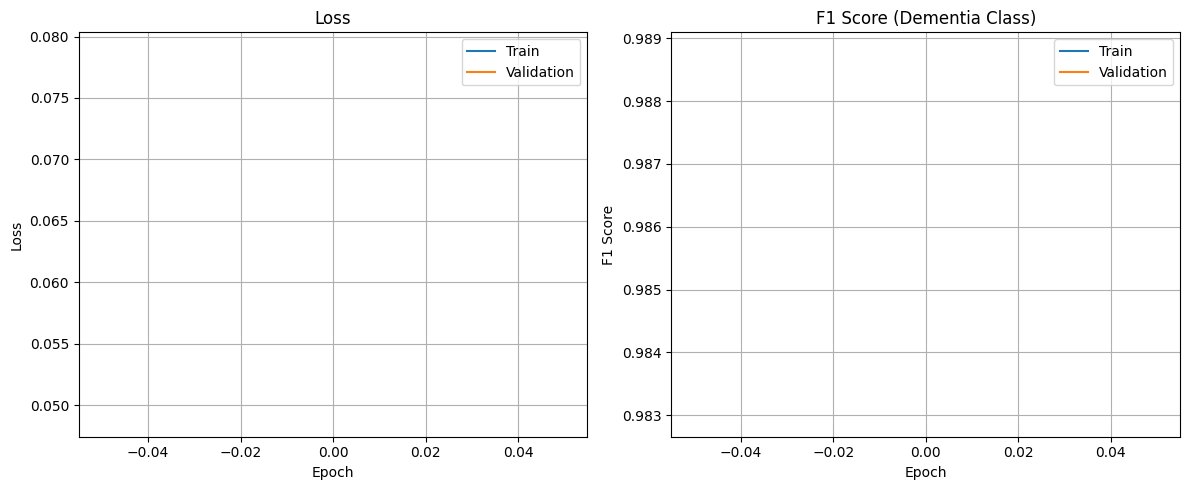

Loading best model state from checkpoint: ..\data\processed\checkpoint_phase2_binary_final_data.pt
Best model loaded (Epoch 1, Val F1: 0.9888)


In [14]:
# Cell 15: Phase 2 Training Call (Updated)

# --- Phase 2 Training ---
num_epochs_phase2 = 1 # MODIFIED - Run only ONE epoch on the full dataset for fine-tuning

if start_epoch_phase2 < num_epochs_phase2:
    print(f"\n--- Starting/Resuming Phase 2 (Epochs {start_epoch_phase2 + 1} to {num_epochs_phase2}) ---")
    model.unfreeze_feature_extractor() # Ensure correct state

    # Create optimizer/scheduler for PHASE 2
    optimizer_phase2 = optim.AdamW(
        model.parameters(), # Train all parameters
        lr=1e-5, # Lower LR
        weight_decay=0.01
    )
    # Adjust steps based on remaining epochs
    total_steps_phase2 = len(train_loader) * (num_epochs_phase2 - start_epoch_phase2)
    warmup_steps_phase2 = int(0.1 * total_steps_phase2) if total_steps_phase2 > 0 else 0
    scheduler_phase2 = optim.lr_scheduler.LinearLR(
        optimizer_phase2, start_factor=0.1, end_factor=1.0, total_iters=max(1, warmup_steps_phase2)
    )

    # Load states if resuming this specific phase
    if optimizer_state_phase2:
        print("Loading Phase 2 optimizer state...")
        optimizer_phase2.load_state_dict(optimizer_state_phase2)
    if scheduler_state_phase2 and scheduler_phase2:
        print("Loading Phase 2 scheduler state...")
        scheduler_phase2.load_state_dict(scheduler_state_phase2)
    if scaler_state_phase2 and scaler.is_enabled(): # <-- Load scaler state
        print("Loading Phase 2 GradScaler state...")
        scaler.load_state_dict(scaler_state_phase2)

    # Run training for phase 2
    model = train_model(
        model=model, train_loader=train_loader, val_loader=val_loader,
        optimizer=optimizer_phase2, scheduler=scheduler_phase2,
        num_epochs=num_epochs_phase2, device=device, phase_name="phase2_binary",
        start_epoch=start_epoch_phase2, best_val_f1=best_val_f1_phase2
    )
else:
     print("\n--- Skipping Phase 2 (already completed according to checkpoint) ---")
     # If skipping, ensure the BEST model from phase 2 checkpoint is loaded
     if phase2_checkpoint_path.exists():
          print("Loading final Phase 2 model state directly...")
          final_phase2_checkpoint = torch.load(phase2_checkpoint_path, map_location=device)
          model.load_state_dict(final_phase2_checkpoint['model_state_dict'])
          best_val_f1_phase2 = final_phase2_checkpoint['best_val_f1']
          print(f"Phase 2 Best Val F1: {best_val_f1_phase2:.4f}")
     # If phase 2 checkpoint doesn't exist but phase 1 did, model holds best phase 1 state
     elif phase1_checkpoint_path.exists():
          print("Phase 2 checkpoint not found, model holds best state from Phase 1.")
     else:
          print("No checkpoints found, model is in initial state.")



# # Cell 15: Phase 2 Training Call (Updated)

# # --- Phase 2 Training ---
# num_epochs_phase2 = 5 # More epochs for fine-tuning

# if start_epoch_phase2 < num_epochs_phase2:
#     print(f"\n--- Starting/Resuming Phase 2 (Epochs {start_epoch_phase2 + 1} to {num_epochs_phase2}) ---")
#     model.unfreeze_feature_extractor() # Ensure correct state

#     # Create optimizer/scheduler for PHASE 2
#     optimizer_phase2 = optim.AdamW(
#         model.parameters(), # Train all parameters
#         lr=1e-5, # Lower LR
#         weight_decay=0.01
#     )
#     # Adjust steps based on remaining epochs
#     total_steps_phase2 = len(train_loader) * (num_epochs_phase2 - start_epoch_phase2)
#     warmup_steps_phase2 = int(0.1 * total_steps_phase2) if total_steps_phase2 > 0 else 0
#     scheduler_phase2 = optim.lr_scheduler.LinearLR(
#         optimizer_phase2, start_factor=0.1, end_factor=1.0, total_iters=max(1, warmup_steps_phase2)
#     )

#     # Load states if resuming this specific phase
#     if optimizer_state_phase2:
#         print("Loading Phase 2 optimizer state...")
#         optimizer_phase2.load_state_dict(optimizer_state_phase2)
#     if scheduler_state_phase2 and scheduler_phase2:
#         print("Loading Phase 2 scheduler state...")
#         scheduler_phase2.load_state_dict(scheduler_state_phase2)
#     if scaler_state_phase2 and scaler.is_enabled(): # <-- Load scaler state
#         print("Loading Phase 2 GradScaler state...")
#         scaler.load_state_dict(scaler_state_phase2)

#     # Run training for phase 2
#     model = train_model(
#         model=model, train_loader=train_loader, val_loader=val_loader,
#         optimizer=optimizer_phase2, scheduler=scheduler_phase2,
#         num_epochs=num_epochs_phase2, device=device, phase_name="phase2_binary",
#         start_epoch=start_epoch_phase2, best_val_f1=best_val_f1_phase2
#     )
# else:
#      print("\n--- Skipping Phase 2 (already completed according to checkpoint) ---")
#      # If skipping, ensure the BEST model from phase 2 checkpoint is loaded
#      if phase2_checkpoint_path.exists():
#           print("Loading final Phase 2 model state directly...")
#           final_phase2_checkpoint = torch.load(phase2_checkpoint_path, map_location=device)
#           model.load_state_dict(final_phase2_checkpoint['model_state_dict'])
#           best_val_f1_phase2 = final_phase2_checkpoint['best_val_f1']
#           print(f"Phase 2 Best Val F1: {best_val_f1_phase2:.4f}")
#      # If phase 2 checkpoint doesn't exist but phase 1 did, model holds best phase 1 state
#      elif phase1_checkpoint_path.exists():
#           print("Phase 2 checkpoint not found, model holds best state from Phase 1.")
#      else:
#           print("No checkpoints found, model is in initial state.")


--- Evaluating BEST model on test set ---


Testing:   0%|                                                                                | 0/1233 [00:00<?, ?it/s]D:\Cornell\Academic\Spring 2025\Startup Studio\MVP\neurotone\ml\.venv\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Testing:   8%|█████▌                                                                 | 96/1233 [00:10<02:10,  8.69it/s]

Testing:  10%|██████▉                                                               | 122/1233 [00:13<02:02,  9.09it/s]

Testing:  18%|████████████▍                                                         | 219/1233 [00:24<01:55,  8.81it/s]

Testing:  21%|██████████████▉                                                       | 263/1233 [00:29<01:49,  8.87it/s]

Testing:  38%|██████████████████████████▋                                           | 469/1233 [00:53<01:32,  8.28it/s]

Testing:  65%|█████████████████████████████████████████████▊                        | 807/1233 [01:34<00:47,  8.90it/s]

Testing:  74%|███████████████████████████████████████████████████▌                  | 909/1233 [01:45<00:36,  8.90it/s]

Testing: 100%|█████████████████████████████████████████████████████████████████████| 1233/1233 [02:22<00:00,  8.64it/s]


ROC AUC: 0.9984

--- Test Set Results (Binary Classification) ---
Accuracy: 0.9901
Dementia (Pos Class) Precision: 0.9939
Dementia (Pos Class) Recall: 0.9862
Dementia (Pos Class) F1 Score: 0.9900
No Dementia (Neg Class) F1 Score: 0.9901


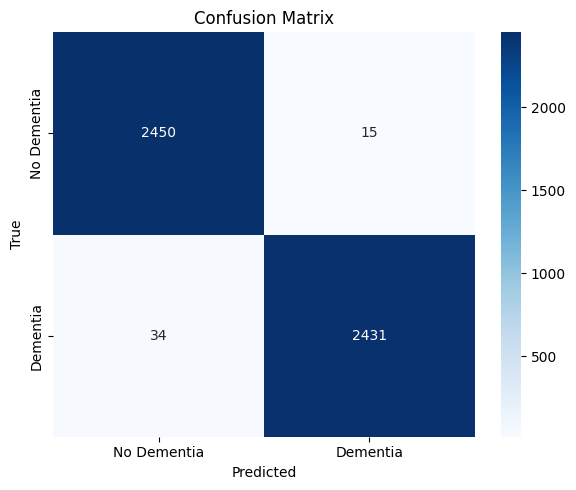


Final model state saved to: ..\data\processed\final_model_binary_segmented_balanced.pt

--- Model training and evaluation completed! ---


In [16]:
# Cell 16: Final Evaluation (Updated)

print("\n--- Evaluating BEST model on test set ---")
# Model should be loaded with the best weights from train_model return

model.eval()
y_true, y_pred = [], []
y_probs = [] # Store probabilities for potential threshold tuning later

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        input_values = inputs['input_values'].to(device)
        attention_mask = inputs.get('attention_mask', None)
        if attention_mask is not None:
            attention_mask = attention_mask.to(torch.bool).to(device)

        # Use autocast for consistency
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            outputs = model(input_values=input_values, attention_mask=attention_mask)

        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > 0.5).squeeze(1).long() # Threshold at 0.5

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
        y_probs.extend(probabilities.squeeze(1).cpu().numpy()) # Store probabilities

# --- Compute and display test metrics ---
accuracy = accuracy_score(y_true, y_pred)
precision_pos = precision_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0)
recall_pos = recall_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0)
f1_pos = f1_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0)
f1_neg = f1_score(y_true, y_pred, pos_label=0, average='binary', zero_division=0)
# Add ROC AUC if desired
try:
    from sklearn.metrics import roc_auc_score
    roc_auc = roc_auc_score(y_true, y_probs)
    print(f"ROC AUC: {roc_auc:.4f}")
except ImportError:
    print("Skipping ROC AUC calculation (sklearn needs update or import error)")
    roc_auc = None

print("\n--- Test Set Results (Binary Classification) ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Dementia (Pos Class) Precision: {precision_pos:.4f}")
print(f"Dementia (Pos Class) Recall: {recall_pos:.4f}")
print(f"Dementia (Pos Class) F1 Score: {f1_pos:.4f}")
print(f"No Dementia (Neg Class) F1 Score: {f1_neg:.4f}")


# Plot confusion matrix using binary class names
plot_confusion_matrix(y_true, y_pred, class_names) # class_names is ['No Dementia', 'Dementia']

# --- Save the final model state (best one loaded from training) ---
# Save to output_dir with descriptive name
final_model_path = output_dir / 'final_model_binary_segmented_balanced.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'test_metrics': {
        'accuracy': accuracy,
        'precision_dementia': precision_pos,
        'recall_dementia': recall_pos,
        'f1_dementia': f1_pos,
        'f1_nodementia': f1_neg,
        'roc_auc': roc_auc
    },
    # Include info about the data used
    'training_metadata': {
        'train_file': str(train_metadata_path.name), # Use correct variable name
        'val_file': str(val_metadata_path.name),   # Use correct variable name
        'test_file': str(test_metadata_path.name)    # Use correct variable name
    }
}, final_model_path)

print(f"\nFinal model state saved to: {final_model_path}")
print("\n--- Model training and evaluation completed! ---")